## Import packages and Connect to Neo4j instance

In [11]:
import csv
import json
import matplotlib.pyplot as plt
from neo4j import GraphDatabase
from path_queries import direct_queries, complex_queries, get_connect_objects, get_failure_mode

## Functions

In [8]:
# Function for list of dictionaries to json file
def list_to_json(data, json_file):
    """ Save list of dictionaries to json file """
    with open(json_file, 'w', encoding='utf-8') as f:
        f.write(json.dumps(data, indent=4))

# Function to get entity type
def get_entity_type(properties):
    """ Construct entity class/subclass from properties """
    entity_type = properties["type"]
    if "subtype0" in properties:
        entity_type += "/" + properties["subtype0"]
    if "subtype1" in properties:
        entity_type += "/" + properties["subtype1"]
    return entity_type

# Function to get entity information
def get_entity_info(record, entity):
    """ Extract entity information from record """
    properties = record[f"{entity}_properties"]
    return {
        "name": properties["text"],
        "type": get_entity_type(properties),
        "entry_id": properties["entry_id"]
    }

# Function to remove duplicate paths
def remove_duplicates(paths):
    """ Remove duplicate paths """
    unique_paths = []
    for path in paths:
        if path not in unique_paths:
            unique_paths.append(path)
    return unique_paths

# Function to check validity of paths (if entities come from same entry)
def check_validity(object, event, helper=None):
    """ Check if entities come from same entry """
    object_set = set(object["entry_id"])
    event_set = set(event["entry_id"])
    # Check if there is a common entry_id
    if helper:
        helper_set = set(helper["entry_id"])
        common = object_set & event_set & helper_set
    else:
        common = object_set & event_set
    return bool(common)

# Function to get common entry entity id
def get_common_entry(object, event, helper=None):
    """ Get common entry entity id """
    object_set = set(object["entry_id"])
    event_set = set(event["entry_id"])
    # Check if there is a common entry_id and return it
    if helper:
        helper_set = set(helper["entry_id"])
        common = object_set & event_set & helper_set
    else:
        common = object_set & event_set
    return common.pop() if common else None

# Function to print count of paths (valid and alternate paths)
def print_path_counts(query, paths):
    """ Print count of paths (valid and alternate paths) """
    num_direct, valid_direct = 0, 0
    num_alternate, valid_alternate = 0, 0
    for path in paths:
        if path['alternate']:
            num_alternate += 1
            if path['valid']:
                valid_alternate += 1
        else:
            num_direct += 1
            if path['valid']:
                valid_direct += 1
    total_paths = num_direct + num_alternate
    total_valid = valid_direct + valid_alternate

    print(query["outfile"])
    print(f"{'Direct':<10}{num_direct:<6} ({valid_direct:<3} valid)")
    print(f"{'Alternate':<10}{num_alternate:<6} ({valid_alternate:<3} valid)")
    print(f"{'Total':<10}{total_paths:<6} ({total_valid:<3} valid)")
    print(f"{'-' * 30}")

## Path Matching Functions

In [9]:
# Function to get relation information
def get_alternate_paths(query, record, object, connect_objects, event, valid, event_helper=None, helper=None):
    """ Extract relation information from record """
    alternate_paths = []
    
    # If PhysicalObject has connect relations to other PhysicalObjects
    # connect_relations: hasPart, contains
    for connect_obj in connect_objects:
        # steering pump hose, pump hose, hose 
        if len(connect_obj) > 2:
            continue
        current_obj = object["name"]
        for obj in connect_obj:
            current_obj = f"{obj} {current_obj}"
            path = {"object_name": current_obj}
            if event_helper is not None:
                path['event_name'] = event_helper
            else:
                path['event_name'] = event['name']
            path["valid"] = valid
            path['alternate'] = True
            alternate_paths.append(path)

    # If PhysicalObject has substitute relations to other PhysicalObjects
    # substitute_relations: isA
    for substitute_obj in record["substitute_objects"]:
        path = {"object_name": substitute_obj['text']}
        if event_helper is not None:
            path['event_name'] = event_helper
        else:
            path['event_name'] = event['name']
        path["valid"] = valid
        path['alternate'] = True
        alternate_paths.append(path)

    # If Event has substitute relations to its own Events (Property, Process, State
    # event_substitute: isA
    for substitute_event in record[f"substitute_{query['event']}"]:
        path = {"object_name": object['name']}
        if event_helper is not None and helper is not None:
            if query['outfile'] == 'object_property_state_paths':
                # e.g. no charge
                event_name = f"{helper['name']} {substitute_event['text']}"
            else:
                # e.g. leak fuel
                event_name = f"{substitute_event['text']} {helper['name']}"
            path['event_name'] = event_name
        else:
            path['event_name'] = substitute_event['text']
        path["valid"] = valid
        path['alternate'] = True
        alternate_paths.append(path)

    alternate_paths = remove_duplicates(alternate_paths)
    return alternate_paths

# Function to process query results
def process_query_results(query, results, paths, complex=False):
    """ Process query results and extract relevant information """

    for record in results:
        # PhysicalObject - Equipment
        object_info = get_entity_info(record, "object")
        connect_objects = get_connect_objects(DRIVER, object_info["name"])
        object_name = object_info["name"]

        # Property / Process / State - Undesirable event
        event_info = get_entity_info(record, query["event"])
        event_name = event_info["name"]    

        # Helper entity (if complex query)
        helper_info = None
        if complex:
            helper_info = get_entity_info(record, query["helper"]) # event_info["type"]
            if query['outfile'] == 'object_property_state_paths':
                # e.g. no charge
                event_name = f"{helper_info['name']} {event_info['name']}"
            else:
                # e.g. leak fuel
                event_name = f"{event_info['name']} {helper_info['name']}"

        # Construct path
        path = {
            "object_name": object_name,
            "event_name": event_name,
        }
        
        # Check if path is confirmed valid (entities come from same entry)
        path["valid"] = check_validity(object_info, event_info, helper=None if not complex else helper_info)
        
        path['alternate'] = False # Not an alternate path
        
        # Get failure mode of path
        entry_id = get_common_entry(object_info, event_info, helper=None if not complex else helper_info)
        if entry_id:
            path["failure_mode"] = get_failure_mode(DRIVER, entry_id)

        # Alternate paths (if PhysicalObject has connect or substitute relations)
        if complex: # Pass helper_info in generating alternate paths if complex
            alternate_paths = get_alternate_paths(query, record, object_info, connect_objects, event_info, path['valid'], 
                                                  event_helper=event_name, helper=helper_info)
        else:       # No helper_info if not complex
            alternate_paths = get_alternate_paths(query, record, object_info, connect_objects, event_info, path['valid'])

        # Include paths only if they don't already exist
        potential_paths = [path] + alternate_paths
        for p in potential_paths:
            if p not in paths:
                paths.append(p)

## Run to extract paths from Neo4j instance

In [7]:
# Connect to Neo4j
URI = "bolt://localhost:7687"
USERNAME = "neo4j"
PASSWORD = "password"
DRIVER = GraphDatabase.driver(URI, auth=(USERNAME, PASSWORD))
OUTPATH = "path_patterns/"

with DRIVER.session() as session:
    for query in direct_queries:
        results = session.run(query["query"])
        paths = []
        process_query_results(query, results, paths, complex=False)
        print_path_counts(query, paths)
        list_to_json(paths, f"{OUTPATH}{query['outfile']}.json")

    for query in complex_queries:
        results = session.run(query["query"])
        paths = []
        process_query_results(query, results, paths, complex=True)
        print_path_counts(query, paths)
        list_to_json(paths, f"{OUTPATH}{query['outfile']}.json")

DRIVER.close()

object_property_paths
Direct    26     (26  valid)
Alternate 23     (23  valid)
Total     49     (49  valid)
------------------------------
process_agent_paths
Direct    77     (77  valid)
Alternate 314    (314 valid)
Total     391    (391 valid)
------------------------------
process_patient_paths
Direct    38     (38  valid)
Alternate 231    (231 valid)
Total     269    (269 valid)
------------------------------
state_patient_paths
Direct    293    (293 valid)
Alternate 915    (915 valid)
Total     1208   (1208 valid)
------------------------------
object_property_state_paths
Direct    1      (1   valid)
Alternate 2      (2   valid)
Total     3      (3   valid)
------------------------------
object_process_state_paths
Direct    0      (0   valid)
Alternate 0      (0   valid)
Total     0      (0   valid)
------------------------------
state_agent_activity_paths
Direct    146    (25  valid)
Alternate 865    (111 valid)
Total     1011   (136 valid)
------------------------------
state_a

In [15]:
from llm_generate import get_all_paths

# Get all valid paths
all_paths, _ = get_all_paths(valid=True)

49	paths in object_property_paths
391	paths in process_agent_paths
269	paths in process_patient_paths
1208	paths in state_patient_paths
3	paths in object_property_state_paths
0	paths in object_process_state_paths
607	paths in state_agent_activity_paths
37	paths in state_agent_patient_paths
1231	paths in process_agent_patient_paths
Total number of paths: 3795


## Update Validated Path Functions

In [10]:
# Function to extract invalid paths for human validation
def prepare_path_for_validation():
    """ Extract paths that are not confirmed valid for human validation in csv file. """
    queries = direct_queries + complex_queries
    requires_validation = {}
    for query in queries:
        with open(f"path_patterns/{query['outfile']}.json", encoding='utf-8') as f:
            requires_validation[query['outfile']] = []
            data = json.load(f)
            for path in data:
                # If path does not come from entry and is not an alternate path
                if not path['valid'] and not path['alternate']:
                    requires_validation[query['outfile']].append({
                        "Physical Object": path['object_name'],
                        "Undesirable Event": path['event_name'],
                        "Helper PO/Event": path['helper_name'] if 'helper_name' in path else "",
                        "Valid": ""
                    })

    # Only keep path types that require validation
    requires_validation = {k: v for k, v in requires_validation.items() if v}
                    
    # Save into csv file with headers = [PhysicalObject,UndesirableEvent,Valid]
    # where Valid is to be filled by human with x if valid, and empty if invalid
    with open("path_patterns/paths_to_validate.csv", "w", encoding='utf-8', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=["Physical Object", "Undesirable Event", "Helper PO/Event", "Valid"])
        writer.writeheader()
        for pathtype, paths in requires_validation.items():
            writer.writerow({"Physical Object": pathtype.upper(), "Undesirable Event": "", "Helper PO/Event": "", "Valid": ""})
            for path in paths:
                writer.writerow(path)

# Function to read human validated unconfirmed paths
def read_paths_validated(filepath="path_patterns/paths_to_validate.csv"):
    """ Read csv file and extract human validated paths """
    # Store validated paths in dictionary
    yes_paths, no_paths, unsure_paths = {}, [], []
    with open(filepath, "r", encoding="utf-8") as f:
        reader = csv.reader(f)
        next(reader) # Ignore header
        for row in reader:
            if row[0].endswith("PATHS"):
                pathtype = row[0].lower()
                yes_paths[pathtype] = []
            else:
                if row[3].lower() == 'y':
                    yes_paths[pathtype].append({
                        "object_name": row[0],
                        "event_name1": f"{row[1]} {row[2]}",
                        "event_name2": f"{row[2]} {row[1]}",
                        "valid": True
                    })
                elif row[3].lower() == 'n':
                    no_paths.append([row[0], row[1], row[2]])
                elif row[3].lower() == '?':
                    unsure_paths.append([row[0], row[1], row[2]])
    print(f"Extracted validated paths from '{filepath}'")
    num_yes = sum(len(value) for value in yes_paths.values())
    print(f"Number of y paths: {num_yes}")
    print(f"Number of n paths: {len(no_paths)}")
    print(f"Number of ? paths: {len(unsure_paths)}")
    return yes_paths, no_paths, unsure_paths

# Function to update path json files with human validated unconfirmed paths
def update_paths_validated(valid_paths):
    """ Update path json files with human validated unconfirmed paths """
    # For each path type, open json file and update the fields
    for pathtype, paths in valid_paths.items():
        num_updated = 0
        pathname = f"path_patterns/{pathtype}.json"
        pathfile = open(pathname, "r", encoding="utf-8")
        pathdata = json.load(pathfile)
        pathfile.close()
        for i, path in enumerate(pathdata):
            if not path['valid'] and not path['alternate']:
                for valid in paths:
                    if (path['object_name'] == valid['object_name'] and
                        (path['event_name'] == valid['event_name1'] or
                         path['event_name'] == valid['event_name2'])):
                        path['valid'] = True
                        num_updated += 1
                        for j in range(i+1, len(pathdata)):
                            if pathdata[j]['alternate'] is True:
                                pathdata[j]['valid'] = True
                                num_updated += 1
                            else:
                                break
        list_to_json(pathdata, pathname)
        print(f"{num_updated} paths updated in '{pathname}'")

## Run to update validated paths from csv file

In [11]:
# Run this to get paths to validate
prepare_path_for_validation()

In [11]:
# Run this to update validated paths
paths_to_validate = 'path_patterns/paths_to_validate_mh.csv'
valid_paths, _, _ = read_paths_validated(paths_to_validate)
update_paths_validated(valid_paths)

# Get all updated valid paths
print("\nGetting all updated valid paths...")
all_paths, _ = get_all_paths(valid=True)

Extracted validated paths from 'path_patterns/paths_to_validate_mh.csv'
Number of y paths: 151
Number of n paths: 428
Number of ? paths: 6
471 paths updated in 'path_patterns/state_agent_activity_paths.json'
6 paths updated in 'path_patterns/state_agent_patient_paths.json'
1081 paths updated in 'path_patterns/process_agent_patient_paths.json'

Getting all updated valid paths...
49	paths in object_property_paths
391	paths in process_agent_paths
269	paths in process_patient_paths
1208	paths in state_patient_paths
3	paths in object_property_state_paths
0	paths in object_process_state_paths
607	paths in state_agent_activity_paths
37	paths in state_agent_patient_paths
1231	paths in process_agent_patient_paths
Total number of paths: 3795


## Paths Analysis

In [30]:
def count_events(paths):
    """ Count number of events from paths """
    events = {}
    combine = ["fault", "leak", "crack", "blowing", 
               "replac", "clean", "trip", "damage",
               "missing", "worn", "fail"]
    
    for path in paths:
        event = path['event_name']
        for c in combine:
            if c in event:
                event = c
        if event not in events:
            events[event] = 1
        else:
            events[event] += 1

    events = {k: v for k, v in sorted(events.items(), key=lambda item: item[1], reverse=True)}
    return events

def plot_events(events):
    """ Plot bar graph of events """
    plt.figure(figsize=(6, 3))
    plt.bar(events.keys(), events.values(), color='skyblue')
    plt.xlabel("Undesirable Event")
    plt.ylabel("Count")
    plt.title("Frequency of Events")
    plt.xticks([])
    plt.tight_layout()
    plt.show()

Number of events:
Event                     Count
leak                      1701
unserviceable             241
replac                    238
fault                     172
broken                    172
blown                     137
crack                     111
clean                     92
needs repair              79
needs fitting             68
needs extending           66
weeping                   63
not working               57
worn                      32
blowing                   28
missing                   28
on                        24
fail                      21
found                     21
needs loctite             21
need adjusting            19
need change out           19
seized                    17
popped                    16
movement                  15
out                       15
emptying                  14
low                       14
alarm                     13
trip                      11
no                        11
snapped                   11
noisy         

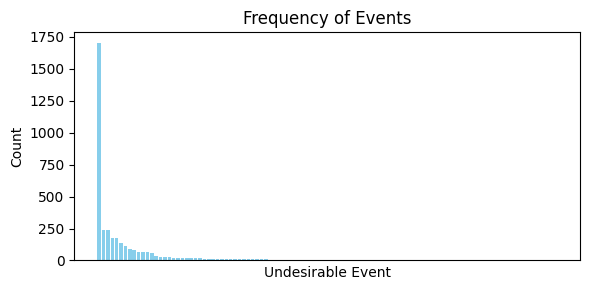

In [31]:
# Count number of events from all paths
events = count_events(all_paths)
print("Number of events:")
print(f"{"Event":<25} Count")
for event, count in events.items():
    print(f"{event:<25} {count}")


plot_events(events)